In [1]:
%matplotlib inline
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from refnx.reflect import SLD, Structure, ReflectModel, use_reflect_backend, Spline, Slab
from refnx.analysis import Parameter, Objective, CurveFitter
from refnx.dataset import ReflectDataset
from ../..platypus-simulate import ReflectSimulator

SyntaxError: invalid syntax (1318017263.py, line 8)

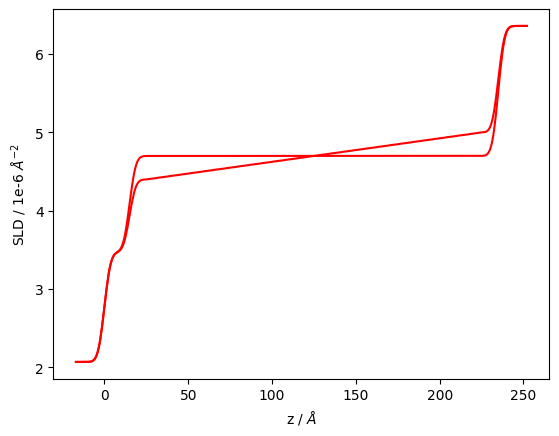

In [69]:
air = SLD(0.0)
si = SLD(2.07)
sio2 = SLD(3.47)
d2o = SLD(6.36)
sld_1_5 = SLD(4.4)
sld_2_0 = SLD(4.7)
sld_2_5 = SLD(5.0)
spl = Spline(200, [], [], zgrad=False)


s = si | sio2(15, 3) | sld_1_5(10, 3) | spl | sld_2_5(10, 3) |  d2o(0, 3)
s_mod = si | sio2(15, 3) | sld_2_0(220, 3) | d2o(0, 3)
model = ReflectModel(s, bkg=1e-6)
model_mod = ReflectModel(s_mod, bkg=1e-6)

fig, ax = s.plot();
s_mod.plot(fig=fig);

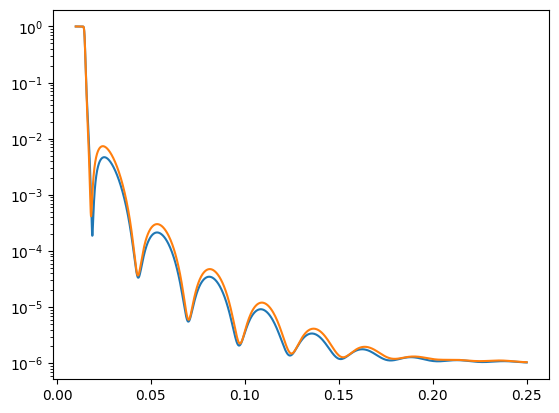

In [70]:
q = np.geomspace(0.01, 0.25, 1001)
plt.plot(q, model(q))
plt.plot(q, model_mod(q));
plt.yscale('log')

In [71]:
simulator0 = ReflectSimulator(model, 0.8, direct_spectrum='PLP0000711.nx.hdf', rebin=2)
simulator1 = ReflectSimulator(model, 3.5, direct_spectrum='PLP0000711.nx.hdf', rebin=2)

In [72]:
simulator0.sample_direct(3000000)
simulator1.sample_direct(3000000)

simulator0.sample(2400000)
for i in tqdm(range(276)):
    # 150e6 beam monitor counts
    simulator1.sample(1000000)


100%|█████████████████████████████████████████| 276/276 [03:48<00:00,  1.21it/s]


In [73]:
data = ReflectDataset()
data += simulator0.reflectivity
data += simulator1.reflectivity

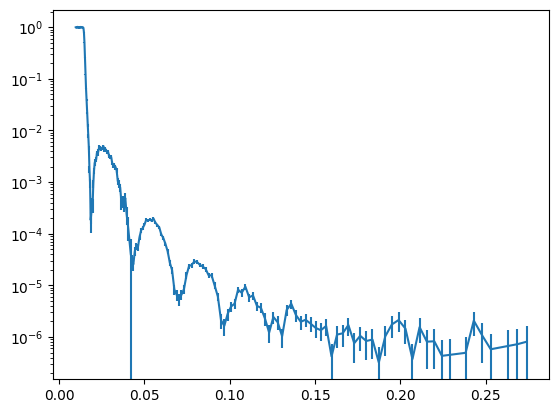

In [74]:
data.plot()
plt.yscale('log')

-907.0883954009823: : 22it [00:00, 43.13it/s]


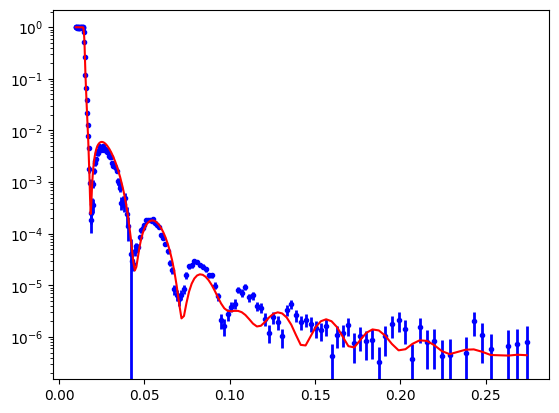

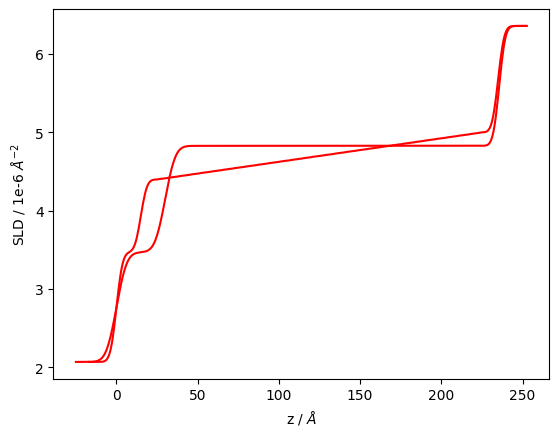

In [101]:
lsld = SLD(3.0)
t = Parameter(200)
r = Parameter(5)
l = Slab(t, lsld, r)
sio2_l = sio2(15, 5)

sfit = si | sio2_l | l | d2o(0, 3)

mfit = ReflectModel(sfit)

sio2_l.thick.setp(vary=True, bounds=(5, 30))
t.setp(vary=True, bounds=(100, 300))
lsld.real.setp(vary=True, bounds=(3, 6))
mfit.bkg.setp(vary=True, bounds=(0, 2e-6))

obj = Objective(mfit, data)
fitter = CurveFitter(obj)

fitter.fit('differential_evolution')
obj.plot()
plt.yscale('log')
fig, ax = sfit.plot()
s.plot(fig=fig);